In [1]:
# import os
# os.getcwd()
# import sys
# sys.path.append('C:\\Users\\kim\\Python\\kang-3DAEM\\conda_3Daem\\kang-2019-3D-aem\\codes')

In [2]:
from discretize import TensorMesh, CylMesh
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
from simpegaem import SimulationAEM
%matplotlib inline

In [3]:
# cell size, number of cells in the x-direction, 
# number of cells in the z-direction and number of padding cells
mesh_type = '2d_cyl'

if mesh_type== '2d_cyl':
    ncx = 10
    csx = 10.
    npadx = 20.
    ncz = 10.
    csz = 5.
    npadz = 18.
    hx = [(csx, ncx), (csx, npadx, 1.3)]
    hz = [(csz, npadz, -1.3), (csz, ncx), (csz, npadz, 1.3)]    
    mesh = CylMesh([hx, 1, hz], x0='00C')
elif mesh_type == '3d_tensor':
    cs, ncx, npad = 10., 9, 8    
    ncy = 1
    ncz = 6
    hx = [(cs, npad, -1.3), (cs, ncx), (cs, npad, 1.3)]
    hy = [(cs, npad, -1.3), (cs, ncy), (cs, npad, 1.3)]    
    hz = [(cs, npad, -1.3), (cs, ncz), (cs, npad, 1.3)]
    mesh = TensorMesh([hx, hy, hz], 'CCC')
active = mesh.cell_centers[:,2] < 0.
sigma_background = 1./20.
sigma_layer = 1./20.
sigma = np.ones(mesh.n_cells)*1e-8
sigma[active] = sigma_background
ind_layer = np.logical_and(mesh.cell_centers[:,2]<-100., mesh.cell_centers[:,2]>-200.)
sigma[ind_layer] = sigma_layer
rho = 1./sigma

/Users/sgkang09/anaconda3/lib/python3.10/site-packages/discretize/utils/code_utils.py:148: FutureWarning: CylMesh has been deprecated, please use CylindricalMesh. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)


In [4]:
from matplotlib.colors import LogNorm
import matplotlib as mpl
mpl.rcParams['font.size'] = 16

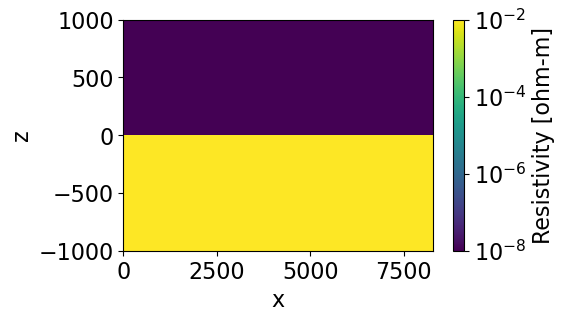

In [5]:
fig, ax = plt.subplots(figsize=(5, 3))
# vmin = np.log10(1e-4); vmax = np.log10(1e-0)
vmin = 1e-8; vmax = 1e-2
out = mesh.plot_image(sigma, ax=ax, pcolor_opts={'norm':LogNorm(vmin=vmin, vmax=vmax)})
ax.set_ylim([-1000, 1000])

cbar = plt.colorbar(out[0])
cbar.set_label('Resistivity [ohm-m]')

In [6]:
from SimPEG import utils
import SimPEG.electromagnetics.time_domain as tdem
from SimPEG import maps
from pymatsolver import PardisoSolver
# from pymatsolver import Solver

In [71]:
receiver_orientation = "z"                    # "x", "y" or "z"
z_src = 30
x_rx = 10.
z_offset = 0.
receiver_location = np.array([x_rx, 0., z_src+z_offset])
source_location = np.array([0., 0., z_src])
times = np.logspace(np.log10(1e-6), np.log10(1e-2), 31)
rx = tdem.receivers.PointMagneticFluxTimeDerivative(
    receiver_location, times, orientation=receiver_orientation
)
receiver_list = [rx]
src = tdem.sources.MagDipole(
    receiver_list=receiver_list, location=source_location,
    waveform=tdem.sources.StepOffWaveform(), orientation='z'
)

# Survey
source_list = [src]
survey = tdem.Survey(source_list)
# dts = np.diff(np.logspace(-7, -1, 60))
# time_steps = []
# for dt in dts:
#     time_steps.append((dt, 1))

def generate_time_steps(
    n_constant_steps=15, increase_rate=3, start_time_step=5e-7, n_per_step=5
):
    time_steps = []
    for i_step in range(n_constant_steps):
        ht = np.ones(n_per_step) * start_time_step*increase_rate**i_step
        time_steps.append(ht)
    print("t_min:{:.1e}, t_max:{:.1e}".format(start_time_step, np.sum(time_steps)))
    return np.hstack(time_steps)

time_steps = generate_time_steps(n_constant_steps=15, increase_rate=2, start_time_step=1e-7, n_per_step=5)

simulation_3d = SimulationAEM(
    mesh=mesh,
    survey=survey,
    sigmaMap=maps.IdentityMap(mesh),
    solver=PardisoSolver,
    time_steps=time_steps
)    
simulation_3d_test = tdem.Simulation3DMagneticFluxDensity(
    mesh=mesh,
    survey=survey,
    sigmaMap=maps.IdentityMap(mesh),
    solver=PardisoSolver,
    time_steps=time_steps    
)

t_min:1.0e-07, t_max:1.6e-02


In [72]:
%%time
data = simulation_3d.dpred(sigma)

CPU times: user 442 ms, sys: 165 ms, total: 607 ms
Wall time: 92 ms


In [73]:
# %%time
# JT = np.zeros((mesh.n_cells, rx.nD), dtype=float)
# data_simpeg = simulation_3d_test.dpred(sigma)
# for ii in range(rx.nD):
#     v = np.zeros(rx.nD)
#     v[ii] = 1
#     JT[:,ii] = simulation_3d_test.Jtvec(sigma, v)

In [74]:
# A^-1 I[:,ii]

In [75]:
# A^-1 I

In [76]:
# O^-1 I

In [77]:
# M = 5e6
# N = 1000
# 1e9

- sigma_local = Mapping(global_model)
- global_model: (Mx1); M > 1e6
- sigma_local; (M_local x 1); ~4e3

P_mappping @ global_model = sigma_local

[M_localxM; sparse matrix]

J_local (n_local x M_local)


J_local @ P_mapping = J

(J_local @ P_mapping) @ vec

(J_local @ P_mapping)^T @ vec

In [78]:
# %%time
# JT @ v

In [79]:
# %%time
# jtvec = simulation_3d_test.Jtvec(sigma, v)

In [80]:
# %%time
# data_simpeg = simulation_3d_test.dpred(sigma)

In [81]:
# x = np.linspace(10, 100, 10)
# y = np.zeros_like(x)
# z = np.ones_like(x) * 30.
# Fz = mesh.getInterpolationMat(np.c_[x, y, z], locType='Fz')
# b0 = src.bInitial(prb)
# bz = Fz*b0
# bza = -1./(4*np.pi*x**3) * mu_0
# plt.semilogy(x, -bz/(np.pi/2), 'k-', )
# plt.semilogy(x, -bz, 'k--', )
# plt.semilogy(x, -bza, 'kx')

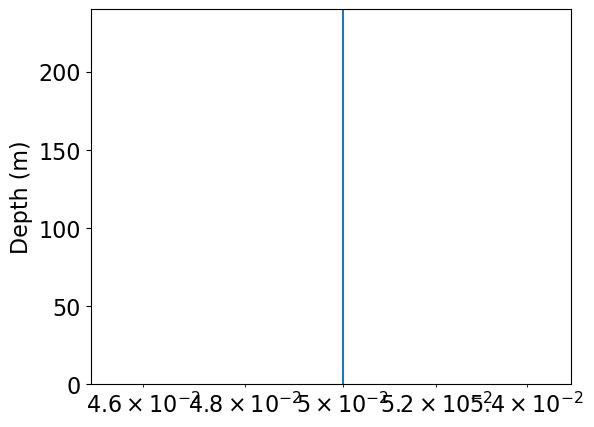

In [82]:
from SimPEG.utils import plot_1d_layer_model

# Layer thicknesses
thicknesses = np.array([100.0, 100.0])
n_layer = len(thicknesses) + 1

# physical property model (conductivity model)
model = sigma_background * np.ones(n_layer)
model[1] = sigma_layer

# Define a mapping from model parameters to conductivities
model_mapping = maps.IdentityMap(nP=n_layer)

# Plot conductivity model
thicknesses_for_plotting = np.r_[thicknesses, 40.0]
mesh_for_plotting = TensorMesh([thicknesses_for_plotting])

fig = plt.figure(figsize=(6, 5))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.75])
plot_1d_layer_model(thicknesses_for_plotting, model, ax=ax, show_layers=False)
plt.gca().invert_yaxis()

In [83]:
# Define the simulation
simulation = tdem.Simulation1DLayered(
    survey=survey,
    thicknesses=thicknesses,
    sigmaMap=model_mapping,
)

# Predict data for a given model
sigma_1d =  model
data_analytic = simulation.dpred(sigma_1d)
data_analytic

array([-1.15176058e-07, -9.14426202e-08, -7.16634707e-08, -5.53298009e-08,
       -4.19969438e-08, -3.12695659e-08, -2.27888489e-08, -1.62226780e-08,
       -1.12598681e-08, -7.60897670e-09, -5.00122180e-09, -3.19584757e-09,
       -1.98560441e-09, -1.20019596e-09, -7.06497186e-10, -4.05569261e-10,
       -2.27416944e-10, -1.24784075e-10, -6.71246532e-11, -3.54651316e-11,
       -1.84377432e-11, -9.44828804e-12, -4.78014589e-12, -2.39123816e-12,
       -1.18437411e-12, -5.81530722e-13, -2.83371883e-13, -1.37171045e-13,
       -6.60179969e-14, -3.16165378e-14, -1.50753717e-14])

In [84]:
# Define the simulation
simulation = tdem.Simulation1DLayered(
    survey=survey,
    sigmaMap=maps.IdentityMap(nP=1),
)

# Predict data for a given model
sigma_1d =  np.ones(1) * sigma_background
data_analytic = simulation.dpred(sigma_1d)
data_analytic

array([-1.15176058e-07, -9.14426202e-08, -7.16634707e-08, -5.53298009e-08,
       -4.19969438e-08, -3.12695659e-08, -2.27888489e-08, -1.62226780e-08,
       -1.12598681e-08, -7.60897670e-09, -5.00122180e-09, -3.19584757e-09,
       -1.98560441e-09, -1.20019596e-09, -7.06497186e-10, -4.05569261e-10,
       -2.27416944e-10, -1.24784075e-10, -6.71246532e-11, -3.54651316e-11,
       -1.84377432e-11, -9.44828804e-12, -4.78014589e-12, -2.39123816e-12,
       -1.18437411e-12, -5.81530722e-13, -2.83371883e-13, -1.37171045e-13,
       -6.60179969e-14, -3.16165378e-14, -1.50753717e-14])

In [85]:
# plt.loglog(times, -data_analytic)
# plt.loglog(times, -data, '.')
# plt.loglog(times, -data_tmp, '--')

In [86]:
# %%time
# data_analytic, _, _ = aem_simulation(1./sigma_background, 1./sigma_background, 10, 10)

In [87]:
# plt.loglog(rx.times, -data/(np.pi/2.), 'kx')
# plt.loglog(rx.times, -data_analytic, 'k')
# plt.loglog(prb.times, np.ones(prb.times.size)*1e-11, 'k|')

In [88]:
b0 = src.bInitial(simulation_3d)

In [89]:
from scipy.interpolate import interp1d

In [90]:
def bdf2(sigma):
    simulation_3d.model = sigma
    # Operators
    C = mesh.edgeCurl
    MfMui = simulation_3d.MfMui
    MeSigma = simulation_3d.MeSigma
    n_steps = simulation_3d.time_steps.size
    Fz = mesh.getInterpolationMat(rx.locations, locType='Fz')
    eps = 1e-10
    def getA(dt, factor=1.):
        return C.T*MfMui*C + factor/dt * MeSigma
    dt_0 = 0.
    sol = np.zeros((mesh.n_edges, simulation_3d.time_steps.size), order='F', dtype=float)
    data_test = np.zeros(simulation_3d.time_steps.size)
    # sol_n0 = np.zeros(mesh.nE)
    # sol_n1 = np.zeros(mesh.nE)
    # sol_n2 = np.zeros(mesh.nE)
    for tInd in range(n_steps):
        dt = simulation_3d.time_steps[tInd]
        #Factor for BDF2
        factor=3/2.            
        if abs(dt_0-dt) > eps:
            # print (tInd, factor)
            A = getA(dt, factor=factor)            
            Ainv = simulation_3d.solver(A)
        if tInd==0:        
            b0 = src.bInitial(simulation_3d)
            s_e = C.T*MfMui*b0
            rhs = factor/dt*s_e
        elif tInd==1:
            rhs = -factor/dt*(MeSigma*(-4/3.*sol[:,tInd-1]+1/3.*sol[:,tInd-2]) + 1./3.*s_e)
        else:
            rhs = -factor/dt*(MeSigma*(-4/3.*sol[:,tInd-1]+1/3.*sol[:,tInd-2]))
        sol[:,tInd] = Ainv*rhs
        data_test[tInd] = Fz*(-C*sol[:,tInd])
        dt_0 = dt
    data_test = (Fz@(-C@sol)).flatten()
    log10_time = np.log10(simulation_3d.time_mesh.cell_centers)
    ht = np.diff(log10_time)
    log10_time_mesh = TensorMesh([ht], x0=[log10_time[0]])
    Pt = log10_time_mesh.get_interpolation_matrix(np.log10(rx.times), location_type='N')        
    # step_func = interp1d(
    #     np.log10(simulation_3d.time_mesh.gridCC[:]), data_test
    # )
    # return step_func(np.log10(rx.times))
    data_bdf2 = Pt @ data_test
    return sol, data_bdf2

In [91]:
# def bdf1(sigma):
#     simulation_3d.model = sigma
#     # Operators
#     C = simulation_3d.mesh.edge_curl
#     # Mfmui = mesh.get_face_inner_product(1./mu_0)
#     # MeSigma = mesh.get_edge_inner_product(sigma)
#     n_steps = simulation_3d.time_steps.size
#     Fz = mesh.get_interpolation_matrix(rx.locations, locType='Fz')
#     eps = 1e-10

#     def getAdiag(tInd):
#         """
#         Diagonal of the system matrix at a given time index
#         """
#         assert tInd >= 0 and tInd < simulation_3d.nT

#         dt = simulation_3d.time_steps[tInd]
#         C = simulation_3d.mesh.edge_curl
#         MfMui = simulation_3d.MfMui
#         MeSigma = simulation_3d.MeSigma
#         return C.T.tocsr() * (MfMui * C) + 1.0 / dt * MeSigma 

#     dt_0 = 0.
#     sol = np.zeros((mesh.n_edges, simulation_3d.time_steps.size), order='F', dtype=float)
#     for tInd in range(n_steps):
#         dt = simulation_3d.time_steps[tInd]
#         A = getAdiag(tInd)
#         if abs(dt_0-dt) > eps:
#             Ainv = simulation_3d.solver(A)
#         if tInd==0:        
#             b0 = src.bInitial(simulation_3d)
#             s_e = C.T*simulation_3d.MfMui*b0
#             rhs = s_e/dt
#         else:
#             rhs = simulation_3d.MeSigma*sol[:,tInd-1]/dt
#         sol[:,tInd] = Ainv*rhs
#         dt_0 = dt
#     data_test = (Fz@(-C@sol)).flatten()
#     # Interpolation in logarithmic space
#     log10_time = np.log10(simulation_3d.time_mesh.cell_centers)
#     ht = np.diff(log10_time)
#     log10_time_mesh = TensorMesh([ht], x0=[log10_time[0]])
#     Pt = log10_time_mesh.get_interpolation_matrix(np.log10(rx.times), location_type='N')
#     # Pt = simulation_3d.time_mesh.get_interpolation_matrix(rx.times, location_type='CC')
#     data_bdf1 = Pt @ data_test  
    
#     # Substituted this with a sparse matrix.
#     # step_func = interp1d(
#     #     np.log10(simulation_3d.time_mesh.cell_centers), data_test
#     # )
#     # return sol, step_func(np.log10(rx.times))
#     return sol, data_bdf1

In [92]:
# data_bdf1 = bdf1()

In [93]:
sol_bdf2, data_bdf2 = bdf2(sigma)

In [94]:
nD = rx.nD

In [95]:
# for src in source_list:
#     rx_list = src.receiver_list:
#     for rx in rx_list:
#         nD += rx.nD

(1e-15, 1e-06)

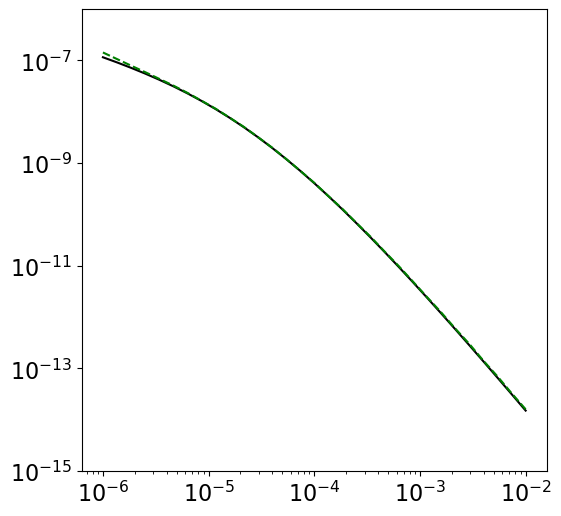

In [96]:
mpl.rcParams['font.size'] = 16
fig, ax = plt.subplots(figsize = (6, 6))
plt.loglog(rx.times, -data_analytic, 'k')
# plt.loglog(rx.times, -data_simpeg, 'r')
# plt.loglog(rx.times, -data_bdf1, 'b--')
plt.loglog(rx.times, -data_bdf2, 'g--')
# plt.legend(("Analytic", "SimPEG", "BDF1", "BDF2"))
# plt.legend(("Analytic", "BDF1", "BDF2"))
ax.set_ylim([1e-15, 1e-6])

In [97]:
C = mesh.edge_curl
log10_time = np.log10(simulation_3d.time_mesh.cell_centers)
ht = np.diff(log10_time)
log10_time_mesh = TensorMesh([ht], x0=[log10_time[0]])
Fz = mesh.get_interpolation_matrix(rx.locations, locType='Fz')
PtT = log10_time_mesh.get_interpolation_matrix(np.log10(rx.times), location_type='N').T.toarray()
# PtT = simulation_3d.time_mesh.get_interpolation_matrix(rx.times, location_type='CC').T.toarray()
PsT = -(Fz@C).T.toarray()

In [98]:
# n_time_steps x n_time_channels

In [99]:
from SimPEG import maps
active_map = maps.InjectActiveCells(mesh, indActive=active, valInactive=np.log(1e-8))
exp_map = maps.ExpMap(mesh)
mapping = exp_map * active_map

In [100]:
m = np.ones(active.sum()) * np.log(1./20.)
sigma = mapping * m

In [101]:
# %%time
# Let's rewrite derivation for BDF2, and check.          ! BIT_061523
def getAdiag(self, tInd):
    """
    Diagonal of the system matrix at a given time index
    """
    assert tInd >= 0 and tInd < self.nT

    dt = self.time_steps[tInd]
    C = self.mesh.edge_curl
    MfMui = self.MfMui
    MeSigma = self.MeSigma
    return C.T.tocsr() * (MfMui * C) + (3./2.) / dt * MeSigma

def getAdiagDeriv(self, tInd, u, v, adjoint=False):
    """
    Deriv of ADiag with respect to electrical conductivity
    """
    assert tInd >= 0 and tInd < self.nT

    dt = self.time_steps[tInd]
    # MeSigmaDeriv = self.MeSigmaDeriv(u)

    if adjoint:
        return (3./2.) / dt * self.MeSigmaDeriv(u, v, adjoint)

    return (3./2.) / dt * self.MeSigmaDeriv(u, v, adjoint)

def getAsubdiag(self, tInd):
    """
    Matrix below the diagonal
    """
    assert tInd >= 0 and tInd < self.nT

    dt = self.time_steps[tInd]
    if tInd == 0:
        factor = -3./2.
    else:
        factor = -2.
    return factor / dt * self.MeSigma

def getAsubdiagDeriv(self, tInd, u, v, adjoint=False):
    """
    Derivative of the matrix below the diagonal with respect to electrical
    conductivity
    """
    dt = self.time_steps[tInd]
    if tInd == 0:
        factor = -3./2.
    else:
        factor = -2.
    if adjoint:
        return factor / dt * self.MeSigmaDeriv(u, v, adjoint)

    return factor / dt * self.MeSigmaDeriv(u, v, adjoint)

def getAsubsubdiag(self, tInd):
    """
    Matrix below the diagonal
    """
    assert tInd >= 0 and tInd < self.nT

    dt = self.time_steps[tInd]

    return 0.5 / dt * self.MeSigma

def getAsubsubdiagDeriv(self, tInd, u, v, adjoint=False):
    """
    Derivative of the matrix below the diagonal with respect to electrical
    conductivity
    """
    dt = self.time_steps[tInd]

    if adjoint:
        return 0.5 / dt * self.MeSigmaDeriv(u, v, adjoint)

    return 0.5 / dt * self.MeSigmaDeriv(u, v, adjoint)

def get_J_sigma_bdf2(sigma):
    simulation_3d.model = sigma
    C = mesh.edgeCurl
    n_steps = simulation_3d.time_steps.size
    eps = 1e-10
    nE = mesh.n_edges
    nD = rx.nD
    nT = len(simulation_3d.time_steps)
    nM = mesh.n_cells
    dt_0 = 0.
    nC = mesh.n_cells
    yn = np.zeros((nE, nD), dtype=float, order='F')
    yn_1 = np.zeros((nE, nD), dtype=float, order='F')
    yn_2 = np.zeros((nE, nD), dtype=float, order='F')
    J_matrixT = np.zeros((nM, nD), dtype=float, order='F')    
    sol, _ = bdf2(sigma)    
    for tInd in reversed(range(n_steps)):
        # print (tInd, tInd-1, tInd-2)
        dt = simulation_3d.time_steps[tInd]
        A = getAdiag(simulation_3d, tInd)
        pn = (PsT * PtT[tInd, :])
        if abs(dt_0-dt) > eps:
            # print (tInd)
            Ainv = simulation_3d.solver(A)
        if tInd==n_steps-1:
            yn = Ainv * pn
        elif tInd==n_steps-2: 
            BB = getAsubdiag(simulation_3d, tInd+1)
            yn = Ainv * (pn-BB@yn_1)   
        else:
            BB = getAsubdiag(simulation_3d, tInd+1)
            CC = getAsubsubdiag(simulation_3d, tInd+2)
            yn = Ainv * (pn-BB@yn_1 -CC@yn_2)   
        dAT_dm = getAdiagDeriv(simulation_3d, tInd, sol[:,tInd], v=None, adjoint=True) @ yn
        if tInd == 0:
            dAsubdiagT_dm = utils.Zero()
            dAsubsubdiagT_dm = utils.Zero()
        elif tInd == 1:
            dAsubdiagT_dm = getAsubdiagDeriv(simulation_3d, tInd, sol[:,tInd-1], v=None, adjoint=True) @ yn
            dAsubsubdiagT_dm = utils.Zero()
        else:
            dAsubdiagT_dm = getAsubdiagDeriv(simulation_3d, tInd, sol[:,tInd-1], v=None, adjoint=True) @ yn
            dAsubsubdiagT_dm = getAsubsubdiagDeriv(simulation_3d, tInd, sol[:,tInd-2], v=None, adjoint=True) @ yn
        J_matrixT = J_matrixT + -dAT_dm - dAsubdiagT_dm - dAsubsubdiagT_dm
        yn_2 = yn_1
        yn_1 = yn
        dt_0 = dt
    return J_matrixT.T

In [102]:
simulation_3d.model = sigma
C = mesh.edgeCurl
n_steps = simulation_3d.time_steps.size
eps = 1e-10
nE = mesh.n_edges
nD = rx.nD
nT = len(simulation_3d.time_steps)
nM = mesh.n_cells
dt_0 = 0.
nC = mesh.n_cells
yn = np.zeros((nE, nD), dtype=float, order='F')

In [103]:
yn.shape

(1410, 31)

g1^T @ yn
[MxnE][nExnD]

J^T = G^T y = [g1^T, g2^T, g3^T] @  [y1, y2, y3]
 = g1^T @ y1 + g2^T @ y2 + ... + gn^T @ yn

In [104]:
%%time
# J_sigma = get_J_sigma_bdf1(sigma)
J_sigma = get_J_sigma_bdf2(sigma)

CPU times: user 3.9 s, sys: 1.13 s, total: 5.03 s
Wall time: 504 ms


In [105]:
v = np.random.randn(rx.nD)

In [106]:
Jtv = simulation_3d_test.Jtvec(sigma, v)

In [107]:
# fig, ax = plt.subplots(figsize = (5,4))
# plt.plot(J_sigma.T @ v,)
# plt.plot(Jtv, '.', ms=5,)

In [108]:
# def dpred(m):
#     sigma = mapping * m    
#     _, dpred = bdf1(sigma)
#     return dpred

# def dpred_dm(m, obs):
#     sigma = mapping * m
#     uncert = abs(obs) * 0.03
#     return utils.sdiag(1./uncert) @ get_J_sigma_bdf1(sigma) * mapping.deriv(m)

# def data_misfit(m, obs):
#     pred = dpred(m)
#     uncert = abs(obs) * 0.03
#     r = (pred-obs) / uncert
#     return np.linalg.norm(r)**2

# def data_misfit_dm(m, obs):
#     pred = dpred(m)
#     uncert = abs(obs) * 0.03
#     r = (pred-obs) / uncert
#     J = dpred_dm(m, obs)
#     return 2*J.T@r

In [109]:
def dpred(m):
    sigma = mapping * m    
    _, dpred = bdf2(sigma)
    return dpred

def dpred_dm(m, obs):
    sigma = mapping * m
    uncert = abs(obs) * 0.03
    return utils.sdiag(1./uncert) @ get_J_sigma_bdf2(sigma) * mapping.deriv(m)

def data_misfit(m, obs):
    pred = dpred(m)
    uncert = abs(obs) * 0.03
    r = (pred-obs) / uncert
    return np.linalg.norm(r)**2

def data_misfit_dm(m, obs):
    pred = dpred(m)
    uncert = abs(obs) * 0.03
    r = (pred-obs) / uncert
    J = dpred_dm(m, obs)
    return 2*J.T@r

In [110]:
m_true = np.ones(active.sum()) * np.log(1./20.)
m_0 = m_true * 2

In [111]:
# Order test for BDF1 
factors = [0.1, 0.01, 0.001, 0.0001]
m_true = np.ones(active.sum()) * np.log(1./20.)
m_0 = m_true * 2

obs = dpred(m_true)
dm0 = m_0*2

order_1 = np.zeros(len(factors))
order_2 = np.zeros(len(factors))

for ii, factor in enumerate(factors):
    dm = dm0 * factor
    order_1[ii] = np.linalg.norm(
        data_misfit(m_0+dm, obs)-data_misfit(m_0, obs)
    )**2
    order_2[ii] = np.linalg.norm(
        data_misfit(m_0+dm, obs)-data_misfit(m_0, obs)-data_misfit_dm(m_0, obs).dot(dm.T)
    )**2
#     print (">> {:.1e}, {:.1e}, {:.1e}".format(factor, order_1[ii], order_2[ii]))
    if ii > 0:
        ratio_1 = order_1[ii]/order_1[ii-1]
        ratio_2 = order_2[ii]/order_2[ii-1]
        
        print (">> {:.1e}, {:.1e}, {:.1e}, {:.1f}".format(factor, order_1[ii], order_2[ii], np.log10(ratio_1/ratio_2)))
    else:
        print (">> {:.1e}, {:.1e}, {:.1e}, {:.1f}".format(factor, order_1[ii], order_2[ii], np.nan))

>> 1.0e-01, 2.0e+07, 1.5e+06, nan
>> 1.0e-02, 3.0e+05, 1.8e+02, 2.1
>> 1.0e-03, 3.2e+03, 1.8e-02, 2.0
>> 1.0e-04, 3.2e+01, 1.8e-06, 2.0


## Notes: 

- Using a combination of bdf2 - fwd and bdf1 - sensitivity does not provide the second order. 
- It seems the curruent SimPEG TDEM code has some errors. 

## TODOS: 
- Rederive equations for sensitivity-bdf1
- Derive equations for sensitivity-bdf2
- Implement sensitivity for bdf2
- Extension for a general waveform
- Extension for handling multiple sources
- Put together as a simiulation class
- Implementing a global simulation for inversion 

In [112]:
# def dpred(m):
#     return m**2 

# def dpred_dm(m):
#     return np.diag(2*m)

# def data_misfit(m, obs):
#     pred = dpred(m)
#     r = pred-obs 
#     return np.linalg.norm(r)**2

# def data_misfit_dm(m, obs):
#     pred = dpred(m)
#     r = pred-obs
#     J = dpred_dm(m)
#     return 2*J.T@r

In [113]:
# plt.plot(J_matrix.flatten())
# plt.plot(-JT.flatten())